# Differentially Private Arrhythmia Analysis
##### Arin Ghazarian

This notebook contains the code for this paper: https://arxiv.org/abs/2406.13880

Below, we explain how to implement differentially private query release on an arrhythmia database. We also train differentially private arrhythmia classification models.


In [1]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import diffprivlib  as dp
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import math
from sympy import Eq, Symbol, solve,exp

## 1) Estimating the Epsilon
In this section, we will use the method propsed by Hsu et al. to check for what values of epislon our research is feasible based on the budget, average breach cost, and number of subjects/

##### Implementing the Econmic method from Hsu et al.
[J. Hsu et al., "Differential Privacy: An Economic Method for Choosing Epsilon," 2014 IEEE 27th Computer Security Foundations Symposium, Vienna, 2014, pp. 398-410.](https://arxiv.org/pdf/1402.3329.pdf)

$$(e^{\epsilon}-1)EN \leq B$$

In [2]:
B =10000#budget
average_breach_chance=0.08
average_breach_cost_US=429
E_Patient_Expected_US=average_breach_cost_US*average_breach_chance
N=10646

In [3]:
E_Patient_Expected_US

34.32

In [4]:
epsilons = np.linspace(0, 0.3, 1000)   # the parameter
equation=((np.exp(epsilons)-1)*E_Patient_Expected_US*N)-B
epsilon = Symbol('epsilon')
eqn = Eq((exp(epsilon)-1)*E_Patient_Expected_US*N, B)
epsilon_solved=solve(eqn)
print (epsilon_solved)

[0.0270016149367627]


epsilon values smaller than 0.027 work.

Text(0.5, 1.0, 'Feasiable epsilon values < 0.027')

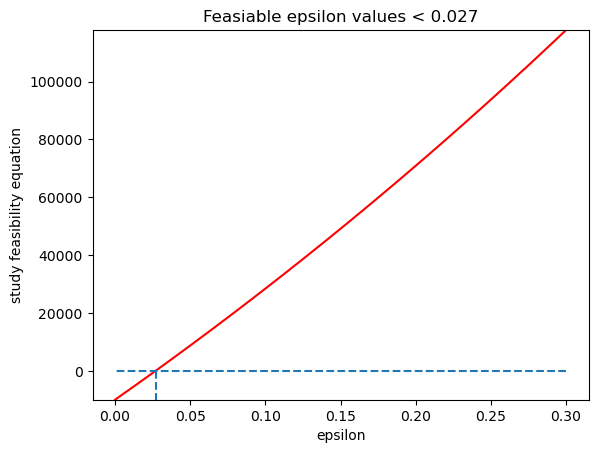

In [5]:
plt.ylim(min(equation), max(equation))
plt.plot(epsilons,equation, 'r')
plt.hlines(0, 0.3, 0, linestyles='dashed')
plt.vlines(0.0270016149367627, 0, min(equation), linestyles='dashed')

plt.xlabel("epsilon")
plt.ylabel("study feasibility equation")
plt.title("Feasiable epsilon values < 0.027")


## 2) Load and Preprocess Data

In [6]:
ecg_file_input_path='/Users/aring/jupyter/data/ECG-PHD/Diagnostics.xlsx'
ecg_df=pd.read_excel(ecg_file_input_path)
ecg_df.head()

,FileName,Rhythm,Beat,PatientAge,DateofBirth,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,01-01-1932,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,01-01-1958,FEMALE,52,52,92,432,401,76,42,8,215,261,431
2,MUSE_20180111_165520_97000,SA,NONE,20,01-01-1996,FEMALE,67,67,82,382,403,88,20,11,224,265,415
3,MUSE_20180113_121940_44000,SB,NONE,66,01-01-1951,MALE,53,53,96,456,427,34,3,9,219,267,447
4,MUSE_20180112_122850_57000,AF,STDD STTC,73,01-01-1943,FEMALE,162,162,114,252,413,68,-40,26,228,285,354


In [7]:
ecg_df.shape

(10646, 17)

In [8]:
Y_df=ecg_df['Rhythm']


In [9]:
arrhytmia_types=Y_df.unique()
arrhytmia_types

array(['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT',
       'SAAWR', 'AVRT'], dtype=object)

In [10]:
corr_matrix=ecg_df.corr()
corr_matrix

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
PatientAge,1.000000,0.032784,0.123134,0.095891,0.095131,0.240466,-0.253646,0.083759,0.031308,0.018093,0.114092,0.098501
VentricularRate,0.032784,1.000000,0.533340,-0.054847,-0.853169,0.421672,0.091437,0.104201,0.997072,0.011266,-0.048688,-0.846037
AtrialRate,0.123134,0.533340,1.000000,-0.060148,-0.474084,0.252017,0.051855,0.050377,0.530587,0.037640,-0.034009,-0.463366
QRSDuration,0.095891,-0.054847,-0.060148,1.000000,0.196121,0.188760,-0.084620,0.009285,-0.053868,-0.424377,0.719834,0.103680
QTInterval,0.095131,-0.853169,-0.474084,0.196121,1.000000,0.025108,-0.123269,-0.056627,-0.850519,-0.082541,0.141702,0.976715
QTCorrected,0.240466,0.421672,0.252017,0.188760,0.025108,1.000000,-0.048156,0.071952,0.420488,-0.125955,0.100727,-0.002145
RAxis,-0.253646,0.091437,0.051855,-0.084620,-0.123269,-0.048156,1.000000,0.046593,0.090857,0.061945,-0.040955,-0.109254
TAxis,0.083759,0.104201,0.050377,0.009285,-0.056627,0.071952,0.046593,1.000000,0.103753,-0.075576,-0.048233,-0.072584
QRSCount,0.031308,0.997072,0.530587,-0.053868,-0.850519,0.420488,0.090857,0.103753,1.000000,0.010224,-0.048463,-0.843626
QOnset,0.018093,0.011266,0.037640,-0.424377,-0.082541,-0.125955,0.061945,-0.075576,0.010224,1.000000,0.323058,0.133192


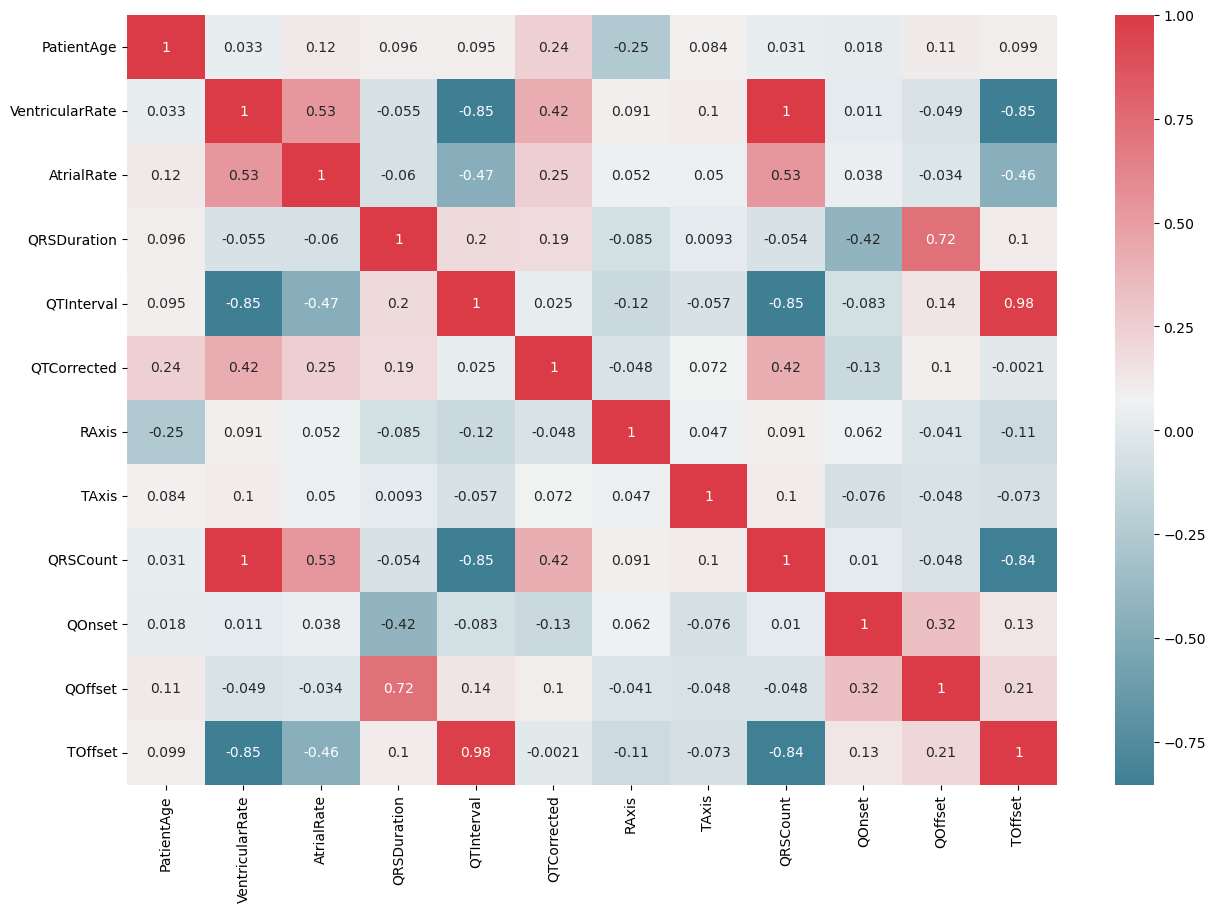

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

sn.heatmap(corr_matrix, annot=True,    cmap=sn.diverging_palette(220, 10, as_cmap=True))
plt.show()

## 3) Train Classifier

### 3.1) prepare input data

In [12]:
from sklearn import preprocessing

labelEncoder = preprocessing.LabelEncoder();
encoded_y=labelEncoder.fit_transform(Y_df)

In [13]:
ecg_df.drop(['DateofBirth'], axis=1,inplace=True)
ecg_df.drop(['Beat'], axis=1,inplace=True)
ecg_df.drop(['FileName'], axis=1,inplace=True)
ecg_df.drop(['Rhythm'], axis=1,inplace=True)


In [14]:
ecg_df['Gender_encoded']=ecg_df['Gender'].map({'MALE':0,'FEMALE':1})


In [15]:
gender_df=ecg_df['Gender_encoded']
ecg_df.drop(['Gender'], axis=1,inplace=True)

In [16]:
# X_train, X_test, y_train, y_test = train_test_split(ecg_df, encoded_y, test_size=0.2)

### 3.2  Calculate ranges/bounds for columns

In [17]:
col_names=ecg_df.columns
ranges_min=[]
ranges_max=[]
bounds_for_forest={}
for i in range(len(col_names)):
    min_val=ecg_df[ecg_df.columns[i]].min()
    max_val=ecg_df[ecg_df.columns[i]].max()
    ranges_min.append(min_val)
    ranges_max.append(max_val)
    bounds_for_forest[col_names[i]]=[min_val,max_val]

bounds = (ranges_min,ranges_max )

In [18]:
bounds

([4, 34, 0, 18, 114, 219, -89, -89, 5, 159, 249, 281, 0],
 [98, 263, 535, 256, 736, 760, 270, 270, 40, 240, 331, 582, 1])

In [19]:
bounds_for_forest

{'PatientAge': [4, 98],
 'VentricularRate': [34, 263],
 'AtrialRate': [0, 535],
 'QRSDuration': [18, 256],
 'QTInterval': [114, 736],
 'QTCorrected': [219, 760],
 'RAxis': [-89, 270],
 'TAxis': [-89, 270],
 'QRSCount': [5, 40],
 'QOnset': [159, 240],
 'QOffset': [249, 331],
 'TOffset': [281, 582],
 'Gender_encoded': [0, 1]}

### 3.3 Train Naive Bayes Classifier Using Cross validation

In [20]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10, random_state=1, shuffle=True)

In [21]:
#non-difpriv model
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from numpy import mean,std

cv = KFold(n_splits=10, random_state=1, shuffle=True)
clf = GaussianNB()

# evaluate model
scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.742 (0.025)


In [22]:
#diff priv model with epsilon 1
from diffprivlib.models import GaussianNB


    
clf = GaussianNB(bounds=bounds,epsilon=100)
# evaluate model
scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.752 (0.017)


#### 3.3.1) Accuracy of the model across  different epsilon values

In [23]:
col_names=ecg_df.columns
ranges_min=[]
ranges_max=[]
for i in range(len(col_names)):
    ranges_min.append(ecg_df[ecg_df.columns[i]].min())
    ranges_max.append(ecg_df[ecg_df.columns[i]].max())

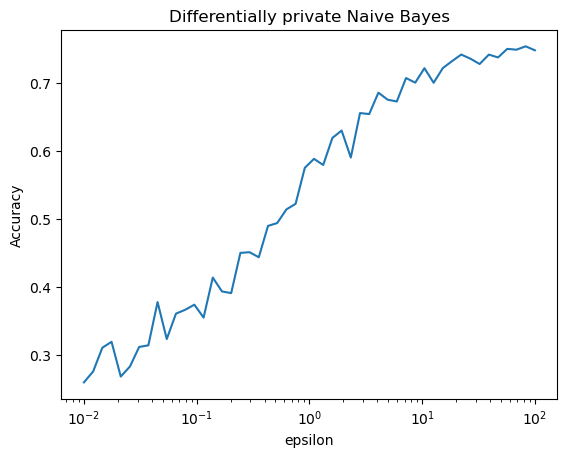

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB

epsilons = np.logspace(-2, 2, 50)
bounds = (ranges_min,ranges_max )
accuracy = list()

for epsilon in epsilons:
    clf = GaussianNB(bounds=bounds, epsilon=epsilon)
    scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)    
    accuracy.append(mean(scores))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private Naive Bayes")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()

### 3.4) Train Logistic Regression Classifier Using Cross validation

In [24]:
import diffprivlib as dp
import numpy as np
from sklearn.linear_model import LogisticRegression

In [25]:

#non-difpriv model
cv = KFold(n_splits=10, random_state=1, shuffle=True)
clf = LogisticRegression()
scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

/Users/aring/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Accuracy: 0.758 (0.014)


/Users/aring/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

diff priv model

In [27]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
dp_clf = dp.models.LogisticRegression(epsilon = 100)
scores = cross_val_score(dp_clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:239: PrivacyLeakWarning: Data norm has not been specified and will be calculated on the data provided.  This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify `data_norm` at initialisation.
  warnings.warn("Data norm has not been specified and will be calculated on the data provided.  This will "
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/lo

Accuracy: 0.652 (0.031)


Differntially private LogisticRegression has a data_norm parameter defines the spread of data that will be protected by differential privacy. If not specified, the max norm is taken from the data during the fit operation but will result in revealing information about the data.  The value for data_norm should be selected using the domain knowledge independently of the data.  The model will clipall the examples to have a 2-norm of at most data_norm specified.

In [28]:
#checking l2 norm in our data
l2_of_all_rows=np.apply_along_axis(np.linalg.norm, 1, ecg_df)
print('l2 of dataframe: %.3f (%.3f)' % (mean(l2_of_all_rows), std(l2_of_all_rows)))
print('max/min l2: %.3f (%.3f)' % (max(l2_of_all_rows), min(l2_of_all_rows)))

l2 of dataframe: 817.887 (46.830)
max/min l2: 1214.288 (581.956)


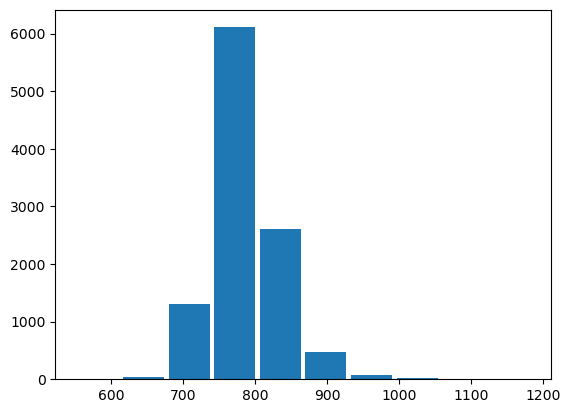

In [29]:
hist, bins = np.histogram(l2_of_all_rows)
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

In [30]:
# with norm clipping
cv = KFold(n_splits=10, random_state=1, shuffle=True)
dp_clf = dp.models.LogisticRegression(epsilon = 100,data_norm=950)
scores = cross_val_score(dp_clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))


/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:419: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:419: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:419: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  warnings.warn("lbfgs failed to converge. Increase the number of iterations.", ConvergenceWarning)
/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/models/logistic_regression.py:419: ConvergenceWarning: lbfgs failed to converge. Inc

Accuracy: 0.625 (0.027)


#### cross validation

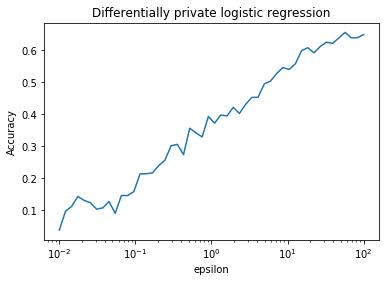

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from diffprivlib.models import GaussianNB

epsilons = np.logspace(-2, 2, 50)
bounds = (ranges_min,ranges_max )
accuracy = list()

for epsilon in epsilons:
    clf = dp.models.LogisticRegression(epsilon = epsilon,data_norm=950)
    scores = cross_val_score(clf, ecg_df, encoded_y, scoring='accuracy', cv=cv, n_jobs=-1)    
    accuracy.append(mean(scores))

plt.semilogx(epsilons, accuracy)
plt.title("Differentially private logistic regression")
plt.xlabel("epsilon")
plt.ylabel("Accuracy")
plt.show()

## 4) Histogram Analysis
### 4.1) Age Distributoin


In [31]:
total_epsilon_budget=0.2

In [32]:
import math

math.exp( total_epsilon_budget )

1.2214027581601699

In [33]:
epsilon_per_histogram=total_epsilon_budget/14

In [34]:
epsilon_per_histogram

0.014285714285714287

In [35]:
ages=ecg_df['PatientAge']
hist, bins = np.histogram(ages)
# hist = hist / hist.sum()

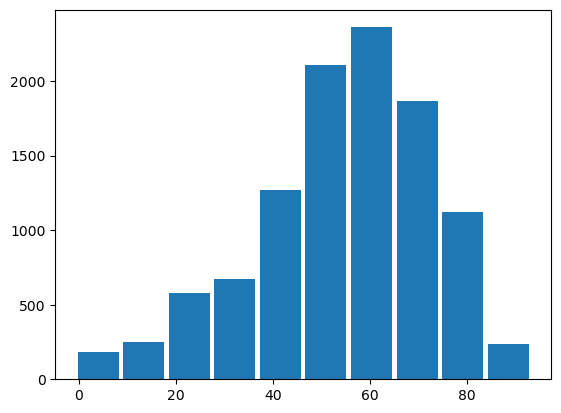

In [36]:
# actual
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.show()

We know from the dataset description that everyone in the dataset is between 4-98 years. We should set the range tto the general bound of this attribute. we'll set the upper bound to 100, As of 2019, less than 0.005% of the world's population is aged over 100. Values above 100 will be excluded from calculations.

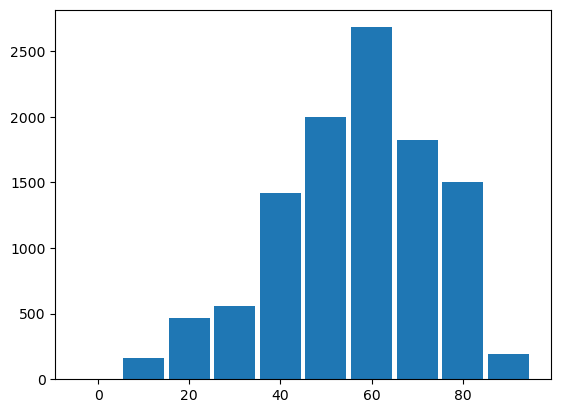

In [37]:
#diff priv histogram
dp_hist, dp_bins = dp.tools.histogram(ages, epsilon=epsilon_per_histogram, range=(0, 100))
# dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.show()

In [38]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())


Total histogram error: 1547.000000


In [39]:
np.all(dp_bins == bins)


False

### 4.2) Gender Distribution

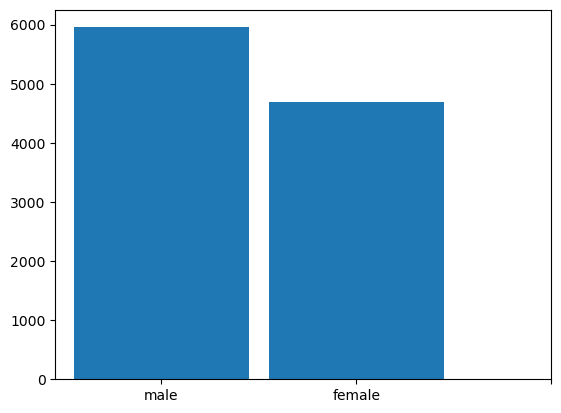

In [63]:
#actual
hist, bins = np.histogram(gender_df,bins=2)
# hist = hist / hist.sum()
plt.bar(bins[:-1], hist, width=(bins[1]-bins[0]) * 0.9)
plt.xticks( bins, ['male','female',''])
plt.show()

# categorical_features = ["male", "female"]
# gender_df.map({0: "male", 1: "female"}).value_counts().plot(kind='bar')


/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/tools/histograms.py:137: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  warnings.warn("Range parameter has not been specified. Falling back to taking range from the data.\n"


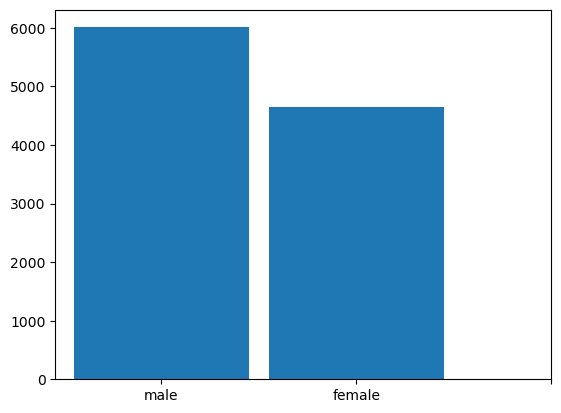

In [64]:
#diff priv
dp_hist, dp_bins = dp.tools.histogram(gender_df, epsilon=epsilon_per_histogram,bins=2)
# dp_hist = dp_hist / dp_hist.sum()

plt.bar(dp_bins[:-1], dp_hist, width=(dp_bins[1] - dp_bins[0]) * 0.9)
plt.xticks( bins, ['male','female',''])

plt.show()


In [48]:
np.all(dp_bins == bins)


True

In [49]:
print("Total histogram error: %f" % np.abs(hist - dp_hist).sum())


Total histogram error: 47.000000


### 4.3) Finding the range of the values

In [50]:
col_names=ecg_df.columns
ranges=[]
for i in range(len(col_names)):
    ranges.append((ecg_df[ecg_df.columns[i]].min(),ecg_df[ecg_df.columns[i]].max()))

In [51]:
col_names

Index(['PatientAge', 'VentricularRate', 'AtrialRate', 'QRSDuration',
       'QTInterval', 'QTCorrected', 'RAxis', 'TAxis', 'QRSCount', 'QOnset',
       'QOffset', 'TOffset', 'Gender_encoded'],
      dtype='object')

In [52]:
ranges

[(4, 98),
 (34, 263),
 (0, 535),
 (18, 256),
 (114, 736),
 (219, 760),
 (-89, 270),
 (-89, 270),
 (5, 40),
 (159, 240),
 (249, 331),
 (281, 582),
 (0, 1)]

In [53]:
VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2



### 4.4) Distribution of ECG measurment variables

##### actual Distribution

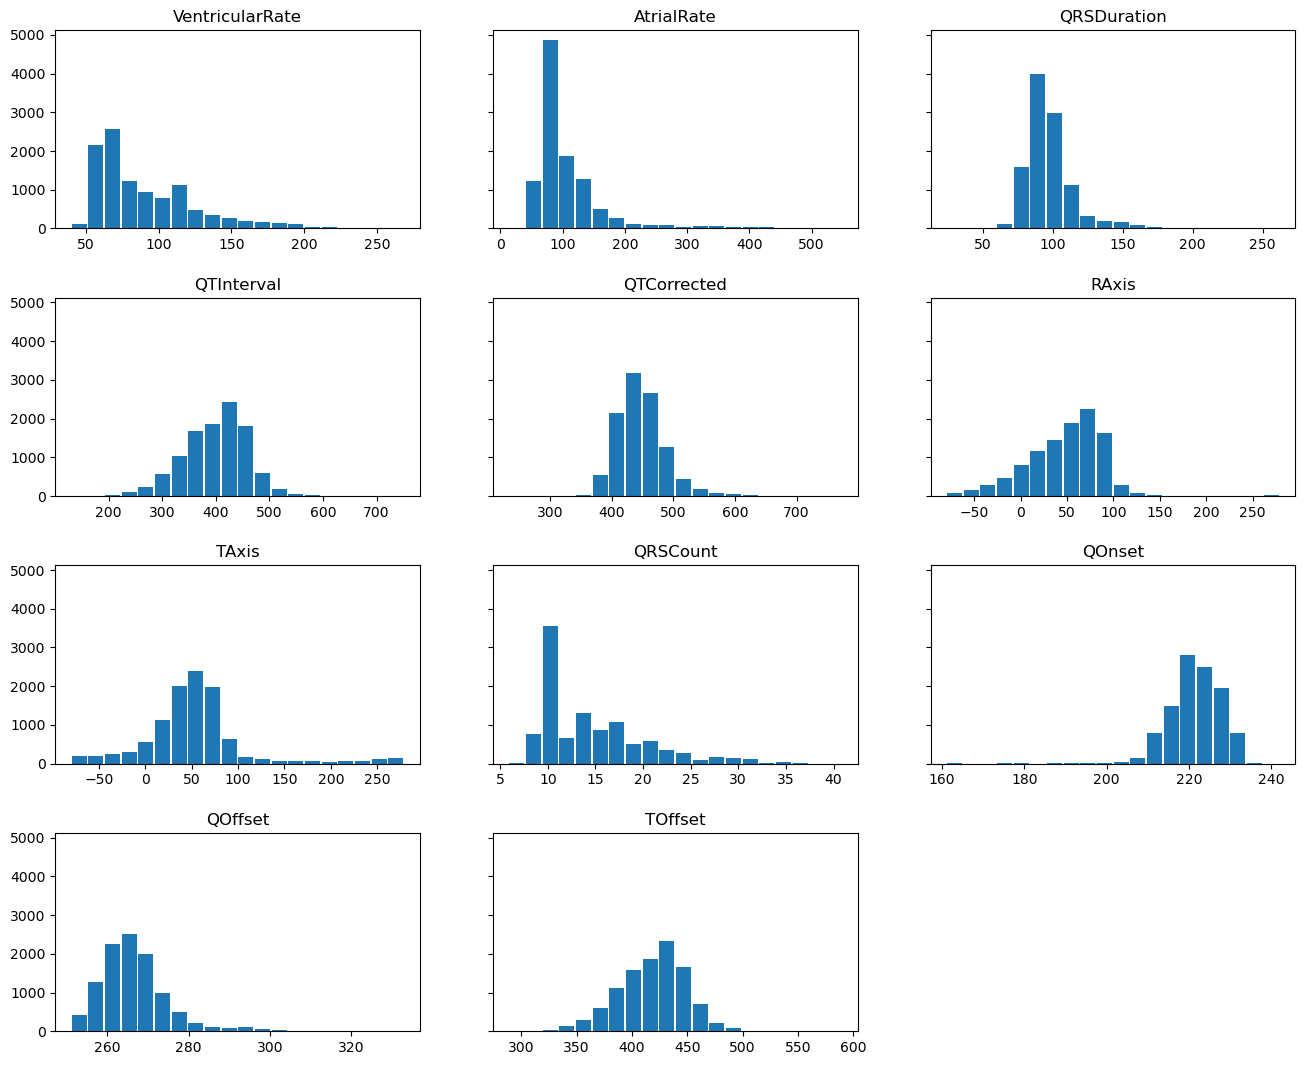

In [54]:
col_names=ecg_df.columns

n_examples = ecg_df.shape[0]

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(16, 13))
fig.subplots_adjust(hspace=0.35)

for i in range(1,12):
    ax = axs.flat[i-1]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 20
    

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = np.histogram(ecg_df.iloc[:, i], bins=n_bins, range=_range)
    ax.bar(bins[:-1] + np.diff(bins), hist , width=bar_width)
#     ax.set_ylim(0, 1)
fig.delaxes(axs[3,2])

plt.show()

#### Diff priv model

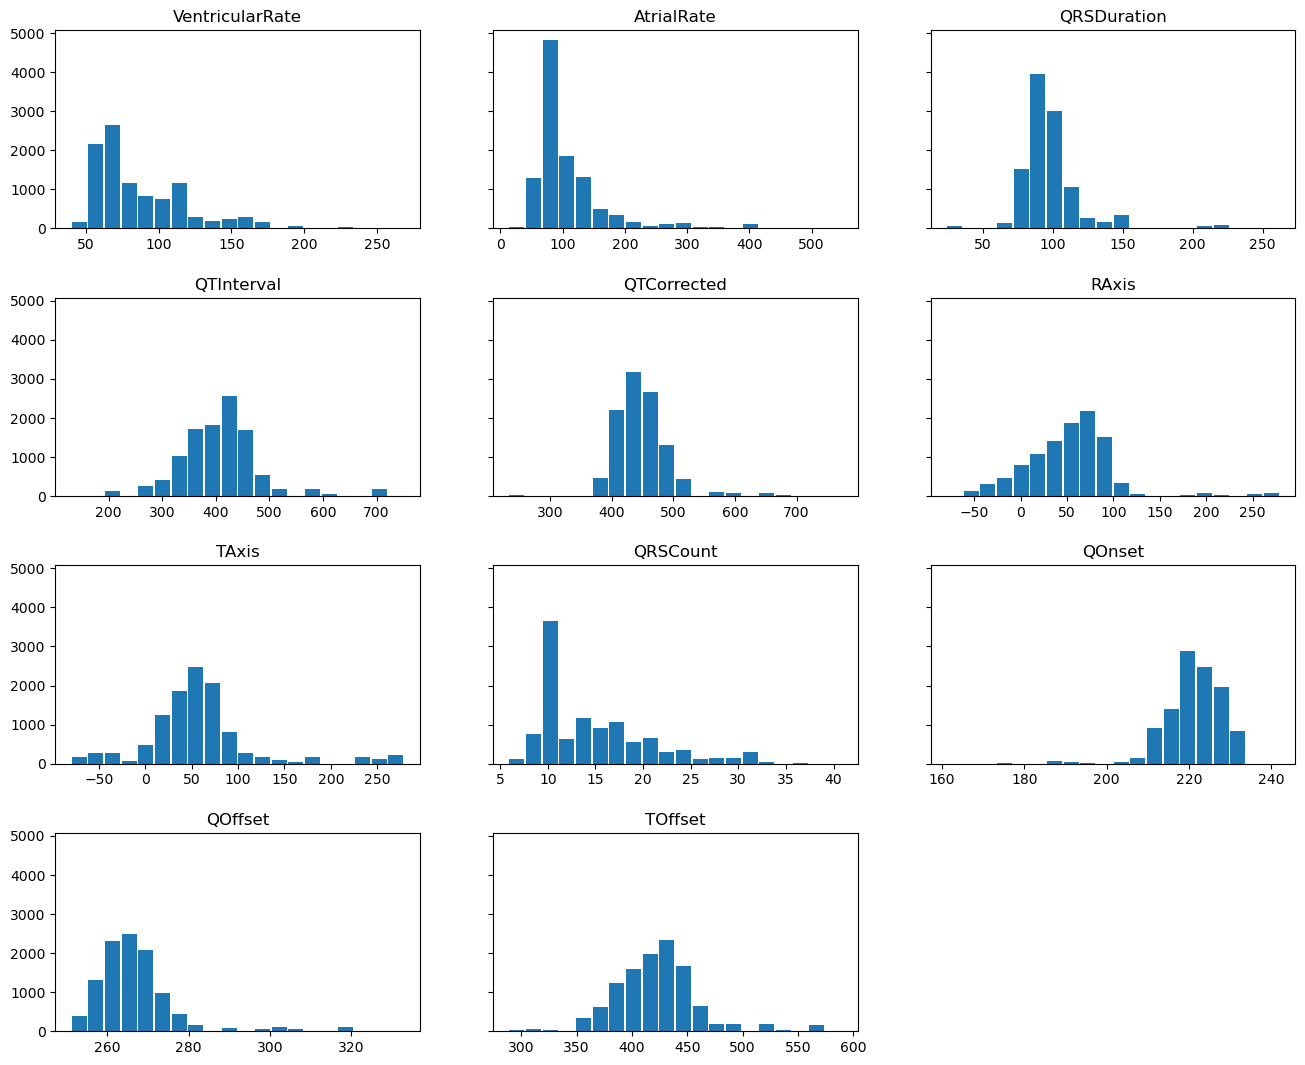

In [55]:
# ecg_df_no_gender=ecg_df.drop(['Rhythm'], axis=1)

col_names=ecg_df.columns

n_examples = ecg_df.shape[0]

fig, axs = plt.subplots(4, 3, sharey=True, figsize=(16, 13))
fig.subplots_adjust(hspace=0.35)

for i in range(1,12):
    ax = axs.flat[i-1]
    ax.set_title(col_names[i])
    _range = ranges[i]
    n_bins = 20
    

    bar_width = (_range[1] - _range[0]) / n_bins * 0.9
    
    hist, bins = dp.tools.histogram(ecg_df.iloc[:, i], bins=n_bins, range=_range, epsilon=epsilon_per_histogram)
    ax.bar(bins[:-1] + np.diff(bins), hist , width=bar_width)
#     ax.set_ylim(0, 1)
fig.delaxes(axs[3,2])
plt.show()

#### 4.5) Disease distribution

In [65]:
Y_df.unique()

array(['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT',
       'SAAWR', 'AVRT'], dtype=object)

In [66]:
Y_df_nums=Y_df.map({'AFIB':0, 'SB':1, 'SA':2, 'AF':3, 'SR':4, 'ST':5, 'SVT':6, 'AT':7, 'AVNRT':8,
       'SAAWR':9, 'AVRT':10})


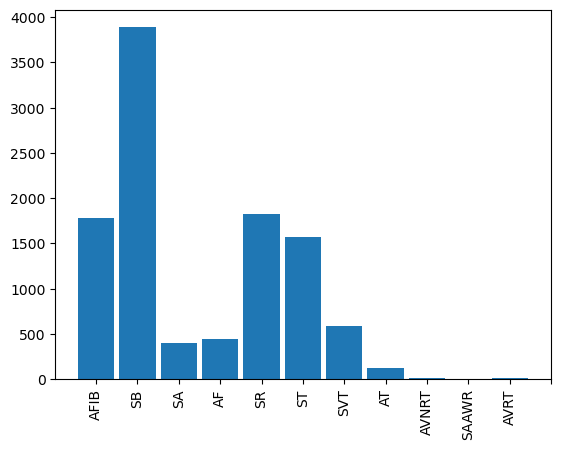

In [67]:
#actual
hist, bins = np.histogram(Y_df_nums,bins=11)
# hist = hist / hist.sum()
plt.bar(bins[:-1], hist)
plt.xticks( bins, ['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT','SAAWR', 'AVRT',''], rotation='vertical')
plt.show()



plt.show()

/Users/aring/opt/anaconda3/lib/python3.9/site-packages/diffprivlib/tools/histograms.py:137: PrivacyLeakWarning: Range parameter has not been specified. Falling back to taking range from the data.
To ensure differential privacy, and no additional privacy leakage, the range must be specified independently of the data (i.e., using domain knowledge).
  warnings.warn("Range parameter has not been specified. Falling back to taking range from the data.\n"


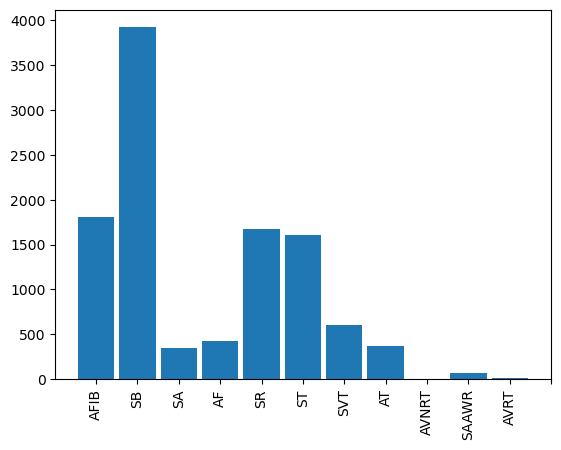

In [69]:
#difpriv

hist, bins = dp.tools.histogram(Y_df_nums, bins=11, epsilon=epsilon_per_histogram)
plt.bar(bins[:-1], hist)
plt.xticks( bins, ['AFIB', 'SB', 'SA', 'AF', 'SR', 'ST', 'SVT', 'AT', 'AVNRT','SAAWR', 'AVRT',''], rotation='vertical')
plt.show()


## 5) Publishing A Differntially Private Report on ECG measurement differences across groups

### 5.1) Mean values report

#### 5.1.1)  Allocating the Privacy Budget

In [70]:
total_epsilon_budget=0.2

acc = dp.BudgetAccountant(total_epsilon_budget, 0)
acc.set_default()

eps_unit=total_epsilon_budget/8


VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [71]:
eps_unit

0.025

#### 5.1.2)  QRS Duration gender differences

In [72]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit*2)


95.03010862923095

In [73]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit*2)


85.02892687593604

#### Actuals

In [74]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QRSDuration_index])


95.16218938885157

In [75]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QRSDuration_index])


85.68997867803839

#### 5.1.3) Ventricular rate Duration gender differences

In [76]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,VentricularRate_index],bounds=ranges[VentricularRate_index],epsilon=eps_unit)


80.90661332170714

In [77]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,VentricularRate_index],bounds=ranges[VentricularRate_index],epsilon=eps_unit)


89.03396170573043

#### Actuals

In [78]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,VentricularRate_index])


81.26108126259234

In [79]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,VentricularRate_index])


87.78720682302772

#### 5.1.4) QTInterval  Duration gender differences

In [80]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QTInterval_index],bounds=ranges[QTInterval_index],epsilon=eps_unit)


384.99677835910467

In [81]:
dp.tools.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QTInterval_index],bounds=ranges[QTInterval_index],epsilon=eps_unit)


382.3345083962415

#### Actuals

In [82]:
np.mean(ecg_df[ecg_df['Gender_encoded']==0].values[:,QTInterval_index])


386.42209536601746

In [83]:
np.mean(ecg_df[ecg_df['Gender_encoded']==1].values[:,QTInterval_index])


381.26652452025587

In [84]:
acc.remaining()

(epsilon=2.2204460492503132e-17, delta=0.0)

In [85]:
acc.total

<bound method BudgetAccountant.total of BudgetAccountant(epsilon=0.2, delta=0, spent_budget=[(0.05, 0), (0.05, 0), (0.025, 0), (0.025, 0), (0.025, 0), ...])>

In [86]:
ranges[QTInterval_index]

(114, 736)

#### 5.1.5) QRS duration changes in Arrhythmias


In [87]:

VentricularRate_index=1
QRSDuration_index=3
QTInterval_index=4
AtrialRat_indexe=2

In [88]:
rhythm_fullname_mapping={'SB':'Sinus Bradycardia','SR':'Sinus Rhythm','AFIB':'Atrial Fibrillation',
                         'ST':'Sinus Tachycardia','AF':'Atrial Flutter','SA':'Sinus Irregularity',
                         'SVT':'Supraventricular Tachycardia','AT':'Atrial Tachycardia',
                         'AVNRT':'Atrioventricular Node Reentrant Tachycardia',
                         'AVRT':'Atrioventricular Reentrant Tachycardia',
                        'SAAWR':'Sinus Atrium to Atrial Wandering Rhythm'}

In [89]:
#actuals
actuals={}
for arrhytmia in arrhytmia_types:
       actuals[rhythm_fullname_mapping[arrhytmia]]=np.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index])



In [90]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{actuals[rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 92.7809\\ \hline
Sinus Bradycardia& 93.3181\\ \hline
Sinus Irregularity& 87.4536\\ \hline
Atrial Flutter& 97.2989\\ \hline
Sinus Rhythm& 87.0044\\ \hline
Sinus Tachycardia& 85.2768\\ \hline
Supraventricular Tachycardia& 96.0545\\ \hline
Atrial Tachycardia& 88.9587\\ \hline
Atrioventricular Node Reentrant Tachycardia& 89.8750\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 84.8571\\ \hline
Atrioventricular Reentrant Tachycardia& 81.5000\\ \hline


In [91]:
dp_means=[]
num_of_runs=2
for i in range(num_of_runs):
    total_epsilon_budget=0.2
    acc = dp.BudgetAccountant(total_epsilon_budget, 0)
    acc.set_default()
    eps_unit=total_epsilon_budget/11
    run={}
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        run[rhythm_fullname_mapping[arrhytmia]]=dp.tools.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)
    dp_means.append(run)
        
        

    

In [92]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{dp_means[0][rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{dp_means[1][rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 116.9904& 95.0456\\ \hline
Sinus Bradycardia& 93.6008& 98.8382\\ \hline
Sinus Irregularity& 193.6831& 90.7631\\ \hline
Atrial Flutter& 115.1262& 105.9543\\ \hline
Sinus Rhythm& 93.8011& 90.4741\\ \hline
Sinus Tachycardia& 96.9619& 85.3447\\ \hline
Supraventricular Tachycardia& 98.4954& 104.0422\\ \hline
Atrial Tachycardia& 179.2813& 143.3764\\ \hline
Atrioventricular Node Reentrant Tachycardia& 18.0000& 256.0000\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 18.0000& 18.0000\\ \hline
Atrioventricular Reentrant Tachycardia& 39.4487& 18.0000\\ \hline


In [93]:
acc.remaining()[0]

1.1102230246251566e-17

#### 5.1.6) Approximate Differential privacy (epsilon+ delta)  

In [94]:
total_delta=1
delta_slack=1/(100*10646)#this delta value guarntees that 99% leak wont happen for each user due to addition of delta
print(f"delta: {delta_slack}")

approx_dp_means=[]
num_of_runs=2
for i in range(num_of_runs):
    total_epsilon_budget=0.2
    acc = dp.BudgetAccountant(epsilon=total_epsilon_budget, delta=total_delta,slack=delta_slack)
    acc.set_default()
    eps_unit=total_epsilon_budget/11
    
    run={}
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        run[rhythm_fullname_mapping[arrhytmia]]=dp.tools.mean(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)
    approx_dp_means.append(run)


delta: 9.393199323689648e-07


In [95]:
acc.remaining()

(epsilon=1.1102230246251566e-17, delta=1.0)

In [96]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{approx_dp_means[0][rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{approx_dp_means[1][rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 109.8369& 85.7968\\ \hline
Sinus Bradycardia& 89.8791& 89.6676\\ \hline
Sinus Irregularity& 132.1460& 92.3076\\ \hline
Atrial Flutter& 112.5701& 94.8421\\ \hline
Sinus Rhythm& 83.8903& 85.7958\\ \hline
Sinus Tachycardia& 73.1678& 115.1284\\ \hline
Supraventricular Tachycardia& 198.9019& 96.6906\\ \hline
Atrial Tachycardia& 52.1051& 18.0000\\ \hline
Atrioventricular Node Reentrant Tachycardia& 243.2555& 18.0000\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 78.4086& 18.0000\\ \hline
Atrioventricular Reentrant Tachycardia& 256.0000& 18.0000\\ \hline


In [97]:
acc.remaining()

(epsilon=1.1102230246251566e-17, delta=1.0)

#### mean values per age group

In [98]:
#FEMALE
num_of_runs=3
for i in range(num_of_runs):
    total_epsilon_budget=0.11
    acc = dp.BudgetAccountant(total_epsilon_budget, 0)
    acc.set_default()

    eps_unit=total_epsilon_budget/11
    ecg_df_female=ecg_df[ecg_df['Gender_encoded']==1]
    print(f'************run: {i+1}**************')
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        print(arrhytmia)
        print('actual: '+str(np.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index])))
        print('dp: '+str (dp.tools.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))


************run: 1**************
AFIB
actual: 88.70906630581868
dp: 31.39482857173916
SB
actual: 86.94460227272727
dp: 84.8873730794957
SA
actual: 82.42045454545455
dp: 256.0
AF
actual: 91.44680851063829
dp: 28.87822944962349
SR
actual: 82.943359375
dp: 80.90239598376823
ST
actual: 81.14434330299089
dp: 46.349091519188356
SVT
actual: 91.8961038961039
dp: 246.85995856320653
AT
actual: 83.05263157894737
dp: 256.0
AVNRT
actual: 91.16666666666667
dp: 256.0
SAAWR
actual: 84.0
dp: 256.0
AVRT
actual: 81.33333333333333
dp: 18.0
************run: 2**************
AFIB
actual: 88.70906630581868
dp: 42.21961836014301
SB
actual: 86.94460227272727
dp: 84.09804163917498
SA
actual: 82.42045454545455
dp: 87.79298005812913
AF
actual: 91.44680851063829
dp: 30.63245495516545
SR
actual: 82.943359375
dp: 125.46594809737591
ST
actual: 81.14434330299089
dp: 99.20680311602246
SVT
actual: 91.8961038961039
dp: 256.0
AT
actual: 83.05263157894737
dp: 18.0
AVNRT
actual: 91.16666666666667
dp: 256.0
SAAWR
actual: 84.0

/var/folders/8v/lk7x_15d4rz139p6ddryvcvr0000gn/T/ipykernel_7551/1725465227.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('actual: '+str(np.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index])))
/var/folders/8v/lk7x_15d4rz139p6ddryvcvr0000gn/T/ipykernel_7551/1725465227.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('dp: '+str (dp.tools.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))


In [99]:
#MALE
num_of_runs=3
for i in range(num_of_runs):
    total_epsilon_budget=0.11
    acc = dp.BudgetAccountant(total_epsilon_budget, 0)
    acc.set_default()

    eps_unit=total_epsilon_budget/11
    ecg_df_female=ecg_df[ecg_df['Gender_encoded']==0]
    print(f'************run: {i+1}**************')
    for arrhytmia in arrhytmia_types:
        print(arrhytmia)
        print('actual: '+str(np.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index])))
        print('dp: '+str (dp.tools.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))


************run: 1**************
AFIB
actual: 95.67146974063401
dp: 152.1086769962696
SB
actual: 96.93510681176944
dp: 100.69247737790153
SA
actual: 91.42600896860986
dp: 18.0
AF
actual: 101.57976653696498
dp: 61.378360205846825
SR
actual: 92.18952618453865
dp: 67.75674616193145
ST
actual: 89.2540675844806
dp: 83.58719191861447
SVT
actual: 100.64516129032258
dp: 18.0
AT
actual: 94.21875
dp: 18.0
AVNRT
actual: 86.0
dp: 18.0
SAAWR
actual: 90.0
dp: 256.0
AVRT
actual: 81.6
dp: 18.0
************run: 2**************
AFIB
actual: 95.67146974063401
dp: 140.47308590154273
SB
actual: 96.93510681176944
dp: 82.71897972833692
SA
actual: 91.42600896860986
dp: 256.0
AF
actual: 101.57976653696498
dp: 117.5987643733506
SR
actual: 92.18952618453865
dp: 232.31775386550265
ST
actual: 89.2540675844806
dp: 94.99225377223867
SVT
actual: 100.64516129032258
dp: 256.0
AT
actual: 94.21875
dp: 18.0
AVNRT
actual: 86.0
dp: 18.0
SAAWR
actual: 90.0
dp: 18.0
AVRT
actual: 81.6
dp: 256.0
************run: 3**************

/var/folders/8v/lk7x_15d4rz139p6ddryvcvr0000gn/T/ipykernel_7551/1297427320.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('actual: '+str(np.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index])))
/var/folders/8v/lk7x_15d4rz139p6ddryvcvr0000gn/T/ipykernel_7551/1297427320.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print('dp: '+str (dp.tools.mean(ecg_df_female[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)))


### 5.2)  Median Values Report

In [100]:
#actuals
median_actuals={}
for arrhytmia in arrhytmia_types:
       median_actuals[rhythm_fullname_mapping[arrhytmia]]=np.median(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index])

        

In [101]:
dp_medians=[]
num_of_runs=2
for i in range(num_of_runs):
    total_epsilon_budget=0.2
    acc = dp.BudgetAccountant(epsilon=total_epsilon_budget)
    acc.set_default()
    eps_unit=total_epsilon_budget/11
    
    run={}
    for arrhytmia in arrhytmia_types:
        if acc.remaining()[0]<eps_unit:
            eps_unit=acc.remaining()[0]
        run[rhythm_fullname_mapping[arrhytmia]]=dp.tools.median(ecg_df[Y_df==arrhytmia].values[:,QRSDuration_index],bounds=ranges[QRSDuration_index],epsilon=eps_unit)
    dp_medians.append(run)





In [102]:
acc.remaining()

(epsilon=1.1102230246251566e-17, delta=1.0)

In [103]:

for arrhytmia in arrhytmia_types:
    print (f'{rhythm_fullname_mapping[arrhytmia]}&{median_actuals[rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{dp_medians[0][rhythm_fullname_mapping[arrhytmia]]: 0.4f}&{dp_medians[1][rhythm_fullname_mapping[arrhytmia]]: 0.4f}\\\\ \\hline')

Atrial Fibrillation& 88.0000& 88.8720& 84.8140\\ \hline
Sinus Bradycardia& 92.0000& 88.8501& 90.0415\\ \hline
Sinus Irregularity& 86.0000& 84.8495& 142.0253\\ \hline
Atrial Flutter& 90.0000& 238.1958& 122.9430\\ \hline
Sinus Rhythm& 86.0000& 115.6134& 85.2430\\ \hline
Sinus Tachycardia& 82.0000& 82.1175& 82.8201\\ \hline
Supraventricular Tachycardia& 84.0000& 87.6161& 227.5658\\ \hline
Atrial Tachycardia& 86.0000& 82.6153& 215.6256\\ \hline
Atrioventricular Node Reentrant Tachycardia& 82.0000& 19.9154& 147.7922\\ \hline
Sinus Atrium to Atrial Wandering Rhythm& 90.0000& 126.4840& 83.5869\\ \hline
Atrioventricular Reentrant Tachycardia& 78.0000& 74.3860& 186.6242\\ \hline
